In [76]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = "/Users/aleksejfilippov/Desktop/earthQuake/data"
path_for_saved_model = "/Users/aleksejfilippov/Desktop/earthQuake/models"

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from IPython.display import clear_output
from sklearn.metrics import f1_score

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=2) for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
dataloaders['test']

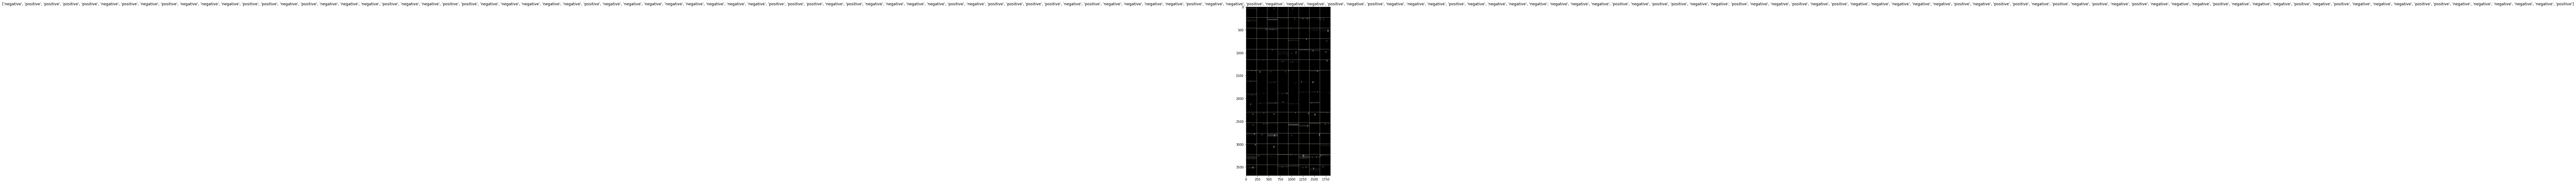

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, padding = 6)

plt.figure(figsize=(20,10))
imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    train_loss, validation_loss = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_score(y_true=labels.cpu().data.numpy(), y_pred=preds.cpu().data.numpy())
            if phase == 'trian':
              train_loss.append(epoch_loss)
            else: # phase == 'validation'
              validation_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1))

            # deep copy the model
            if phase == 'validation' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                # clear_output(True)
                plt.plot(list(range(len(train_loss))), train_loss, label='train loss')
                plt.plot(list(range(len(validation_loss))), validation_loss, label='validation loss')
                plt.legend()
                plt.show()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {predicted} real: {real}'.format(predicted=class_names[preds[j]],
                                                                          real=class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

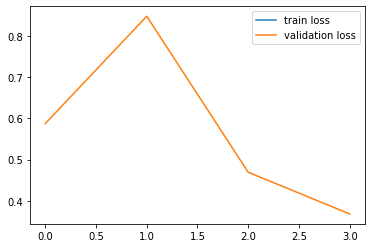


Epoch 2/24
----------
train Loss: 0.4100 Acc: 0.8287 F1: 0.0000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


validation Loss: 0.3279 Acc: 0.8824 F1: 1.0000

Epoch 3/24
----------
train Loss: 0.3791 Acc: 0.8500 F1: 0.0000
validation Loss: 0.2613 Acc: 0.9156 F1: 0.6667

Epoch 4/24
----------
train Loss: 0.3643 Acc: 0.8545 F1: 0.0000
validation Loss: 0.3408 Acc: 0.8787 F1: 1.0000

Epoch 5/24
----------
train Loss: 0.3476 Acc: 0.8616 F1: 1.0000
validation Loss: 0.3826 Acc: 0.9224 F1: 1.0000

Epoch 6/24
----------
train Loss: 0.3498 Acc: 0.8558 F1: 0.0000
validation Loss: 0.8077 Acc: 0.8915 F1: 0.0000

Epoch 7/24
----------
train Loss: 0.3036 Acc: 0.8812 F1: 0.0000
validation Loss: 0.2914 Acc: 0.9314 F1: 1.0000

Epoch 8/24
----------
train Loss: 0.2988 Acc: 0.8788 F1: 0.6667
validation Loss: 0.2984 Acc: 0.9277 F1: 1.0000

Epoch 9/24
----------
train Loss: 0.2934 Acc: 0.8808 F1: 1.0000
validation Loss: 0.2927 Acc: 0.9284 F1: 0.0000

Epoch 10/24
----------
train Loss: 0.2913 Acc: 0.8827 F1: 0.5000
validation Loss: 0.2963 Acc: 0.9254 F1: 1.0000

Epoch 11/24
----------
train Loss: 0.2861 Acc: 0.8872 F

In [139]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

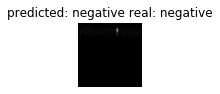

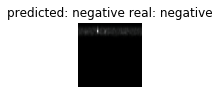

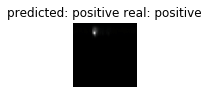

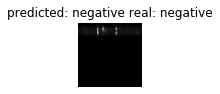

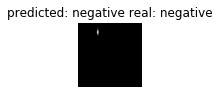

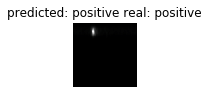

In [152]:
visualize_model(model_ft)

In [8]:
model_name = 'model.pt'
# torch.save(model_ft.state_dict(), path_for_saved_model+model_name)

In [11]:
model_name = 'model.pt'
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
model.load_state_dict(torch.load(os.path.join(path_for_saved_model, model_name), map_location='cpu'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

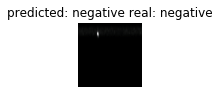

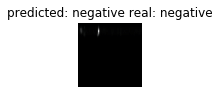

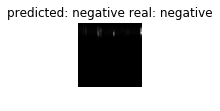

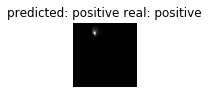

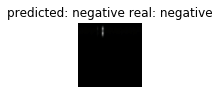

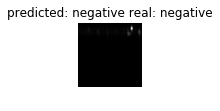

In [15]:
visualize_model(model)